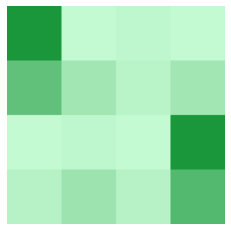

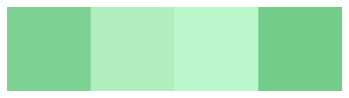

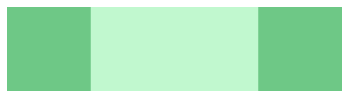

In [41]:
# for dummy attention
import torch
import numpy as np
from matplotlib import pyplot as plt
import cv2

def imshow_attention(mat, output_path=None):
    if isinstance(mat, torch.Tensor):
        mat = mat.detach().cpu().numpy()
    mat = cv2.resize(mat, None, fx=128, fy=128, interpolation=cv2.INTER_NEAREST)
    H, W = mat.shape
    mat = mat.reshape(H, W, 1)
    high_color = np.array([10, 143, 45]).reshape(1,1,3)
    low_color = np.array([199, 252, 213]).reshape(1,1,3)
    mat = mat*high_color + (1-mat)*low_color
    mat = mat.astype(np.uint8)
    plt.imshow(mat)
    # plt.yticks([])
    # plt.xticks([])
    plt.axis('off')
    plt.show()
    if output_path is not None:
        cv2.imwrite(output_path, mat)

score = torch.tensor([
    [5, 1, 2, 1],
    [3, 2, 1, 2],
    [1, 2, 1, 5],
    [1, 2, 1, 3],
], dtype=torch.float32)
prob = torch.softmax(score, dim=-1)
reduced_prob = torch.mean(prob, dim=0, keepdim=True)

imshow_attention(prob, './saves_plot/fig_struct_atten.png')
imshow_attention(reduced_prob, './saves_plot/fig_struct_ff.png')
imshow_attention(torch.mean(prob[[0,2],:], dim=0, keepdim=True), './saves_plot/fig_struct_abt.png')

In [34]:
# flops table
import copy, random
import pandas as pd
from utils import sparse_flops_calculation as calc

SEQ = 128
FACTORS = [4,8,16]
OCCUPIES = [0.2, 0.4, 1.0]
SAMPLES = 1000

cols = []

base_config = calc.ModelConfig(
    num_layer=12,
    num_heads=12,
    hidden_size=768,
    intermediate_size=768*4,
    seq_len=SEQ,
    arch='bert',
    token_occupies=None
)

flops_bert_base = calc.flops_sparse_bert_model(base_config)
print('bert-base', calc.human_readable(flops_bert_base), '100%', sep='\t')
cols.append((('BERT_{base}', ''), [calc.human_readable(flops_bert_base), '100%']))

for factor in FACTORS:
    config = copy.deepcopy(base_config)
    config.hidden_size /= factor
    config.intermediate_size /= factor
    flops_approx_factor = calc.flops_sparse_bert_model(config)
    print(
        f'approx-bert@f{factor}', 
        calc.human_readable(flops_approx_factor), 
        f'{flops_approx_factor/flops_bert_base*100:.2f}%', 
        sep='\t'
    )
    cols.append((
        ('Attention Approx. Net.', f'factor={factor}'), 
        [
            calc.human_readable(flops_approx_factor), 
            f'{flops_approx_factor/flops_bert_base*100:.2f}%',
        ]
    ))

config = copy.deepcopy(base_config)
config.sparse_mode = 'forward'
config.token_occupies = [1.0 for _ in range(config.num_layer+1)]
flops_forward_factor_overhead = calc.flops_sparse_update(config)
print('fwd-overhead', 
    calc.human_readable(flops_forward_factor_overhead),
    f'{flops_forward_factor_overhead/flops_bert_base*100:.2f}%', 
    sep='\t'
)
cols.append((
    ('Overhead of Manual Top-k', f''), 
    [
        calc.human_readable(flops_forward_factor_overhead),
        f'{flops_forward_factor_overhead/flops_bert_base*100:.2f}%', 
    ]
))

for occupy in OCCUPIES:
    flops = 0
    for _ in range(5000):
        config = copy.deepcopy(base_config)
        config.approx_hidden_size = config.hidden_size / 4
        config.approx_intermediate_size = config.intermediate_size / 4
        config.sparse_mode = 'approx'
        config.token_occupies = [random.random() * (0.05+2*(occupy-0.05)) + 0.05 for _ in range(config.num_layer+1)]
        flops += calc.flops_sparse_update(config)
    flops /= 5000
    print(f'abt-oh@{occupy}', 
        calc.human_readable(flops),
        f'{flops/flops_bert_base*100:.2f}%', 
        sep='\t'
    )
    cols.append((
        ('Overhead of Attention Back-tracking', f'{occupy}'), 
        [
            calc.human_readable(flops),
            f'{flops/flops_bert_base*100:.2f}%', 
        ]
    ))

for occupy in OCCUPIES:
    flops = 0
    for _ in range(5000):
        config = copy.deepcopy(base_config)
        config.approx_hidden_size = config.hidden_size / 4
        config.approx_intermediate_size = config.intermediate_size / 4
        config.sparse_mode = 'concrete'
        config.token_occupies = [random.random() * (0.05+2*(occupy-0.05)) + 0.05 for _ in range(config.num_layer+1)]
        flops += calc.flops_sparse_update(config)
    flops /= 5000
    print(f'conc-oh@{occupy}', 
        calc.human_readable(flops),
        f'{flops/flops_bert_base*100:.2f}%', 
        sep='\t'
    )
    cols.append((
        ('Overhead of Concrete Masking', f'{occupy}'), 
        [
            calc.human_readable(flops),
            f'{flops/flops_bert_base*100:.2f}%', 
        ]
    ))

df = pd.DataFrame()
for header, content in cols:
    df[header] = content
df.columns = pd.MultiIndex.from_tuples([(c[0], c[1]) for c in df.columns])
df.index = ['FLOPs', 'Relative %']
df = df.transpose()
df.to_latex('./saves_plot/table_overhead_flops.tex')
df

bert-base	22.4 GFLOPs	100%
approx-bert@f4	1.5 GFLOPs	6.86%
approx-bert@f8	436.9 MFLOPs	1.95%
approx-bert@f16	140.6 MFLOPs	0.63%
fwd-overhead	2.8 MFLOPs	0.01%
abt-oh@0.2	665.5 KFLOPs	0.00%
abt-oh@0.4	1.2 MFLOPs	0.01%
abt-oh@1.0	2.9 MFLOPs	0.01%
conc-oh@0.2	10.4 MFLOPs	0.05%
conc-oh@0.4	19.6 MFLOPs	0.09%
conc-oh@1.0	47.1 MFLOPs	0.21%


/tmp/ipykernel_615774/3293657249.py:115: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex('./saves_plot/table_overhead_flops.tex')


FLOPs Relative %
BERT_{base}                                     22.4 GFLOPs       100%
Attention Approx. Net.              factor=4     1.5 GFLOPs      6.86%
                                    factor=8   436.9 MFLOPs      1.95%
                                    factor=16  140.6 MFLOPs      0.63%
Overhead of Manual Top-k                         2.8 MFLOPs      0.01%
Overhead of Attention Back-tracking 0.2        665.5 KFLOPs      0.00%
                                    0.4          1.2 MFLOPs      0.01%
                                    1.0          2.9 MFLOPs      0.01%
Overhead of Concrete Masking        0.2         10.4 MFLOPs      0.05%
                                    0.4         19.6 MFLOPs      0.09%
                                    1.0         47.1 MFLOPs      0.21%